# Задача 3. Сравнение методов классификации

* **Дедлайн**: 19.11.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [x] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [x] * (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

# Classification Heart Disease Demo

In [869]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import RidgeClassifierCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

## Чтение данных

In [870]:
df = pd.read_csv('./heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Возьмём данные заболеваний сердца у пациентов, которые можно скачать [тут](https://www.kaggle.com/code/ahmedadell30/heart-disease-prediction-with-ann-models/data).

Описание датасета: <br>

* age - age in years <br>
* sex - (1 = male; 0 = female) <br>
* cp - chest pain type <br>
* trestbps - resting blood pressure (in mm Hg on admission to the hospital) <br>
* chol - serum cholestoral in mg/dl <br>
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) <br>
* restecg - resting electrocardiographic results <br>
* thalach - maximum heart rate achieved <br>
* exang - exercise induced angina (1 = yes; 0 = no) <br>
* oldpeak - ST depression induced by exercise relative to rest <br>
* slope - the slope of the peak exercise ST segment <br>
* ca - number of major vessels (0-3) colored by flourosopy <br>
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect <br>
* target - have disease or not (1=yes, 0=no)

Необходимо решить задачу классификации и научиться предсказывать целовой признак **target** имеет ли пациент заболевание сердца.

## EDA

In [871]:
df.target.value_counts()

target
1    526
0    499
Name: count, dtype: int64

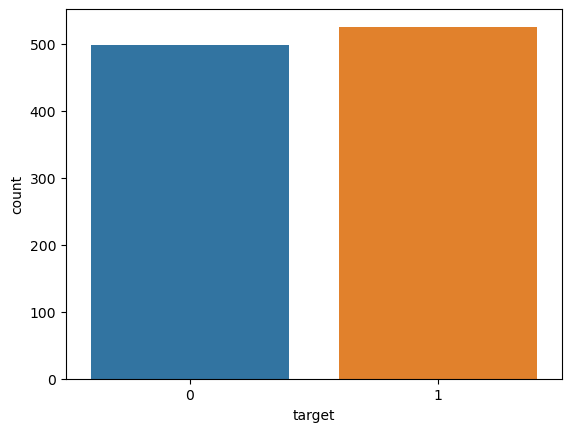

In [872]:
sns.countplot(x="target", data=df)
plt.show()

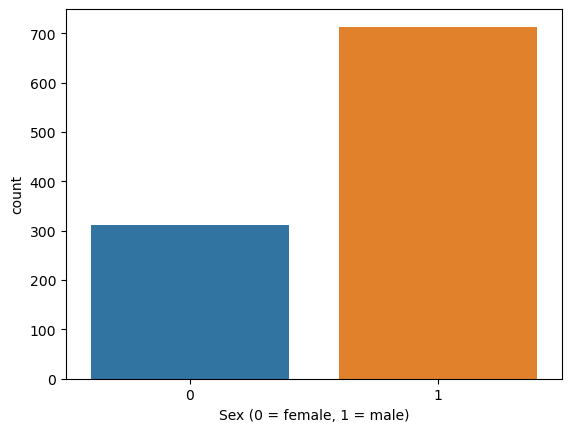

In [873]:
sns.countplot(x='sex', data=df)
plt.xlabel("Sex (0 = female, 1 = male)")
plt.show()

In [874]:
df.groupby('target').mean()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,56.569138,0.827655,0.482966,134.106212,251.292585,0.164329,0.456914,139.130261,0.549098,1.600200,1.166333,1.158317,2.539078
1,52.408745,0.570342,1.378327,129.245247,240.979087,0.134981,0.598859,158.585551,0.134981,0.569962,1.593156,0.370722,2.119772


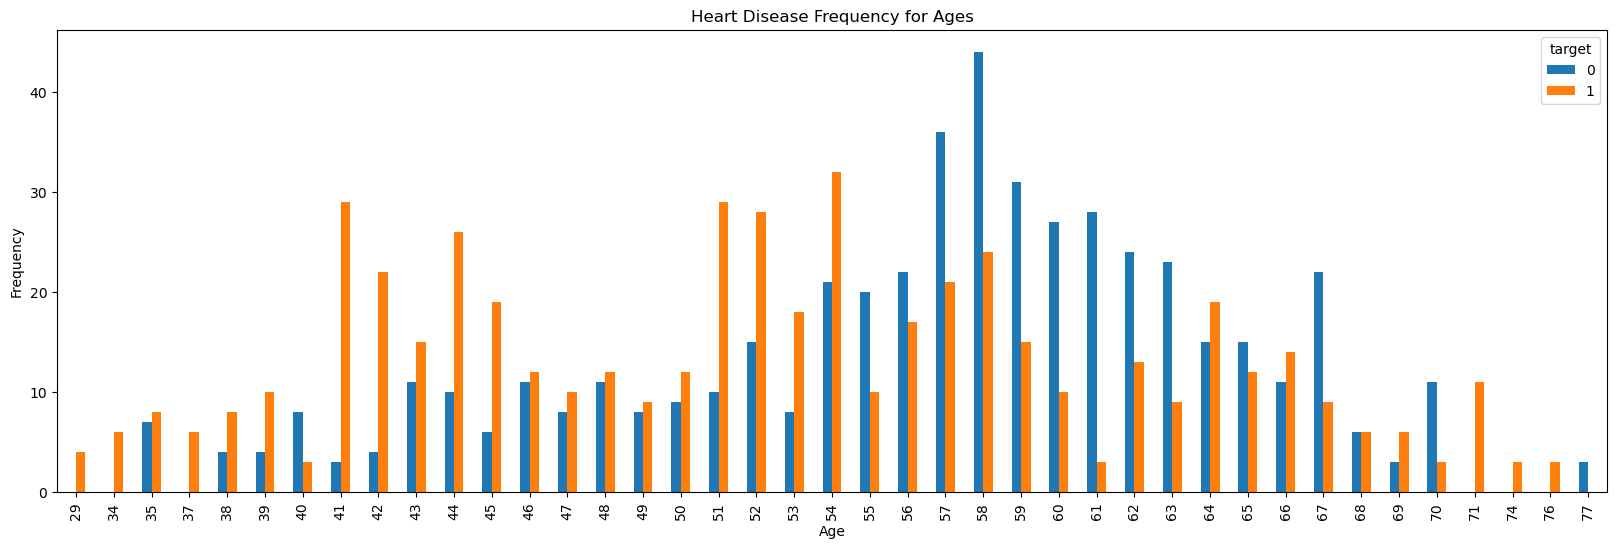

In [875]:
pd.crosstab(df.age,df.target).plot(kind="bar", figsize=(20, 6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

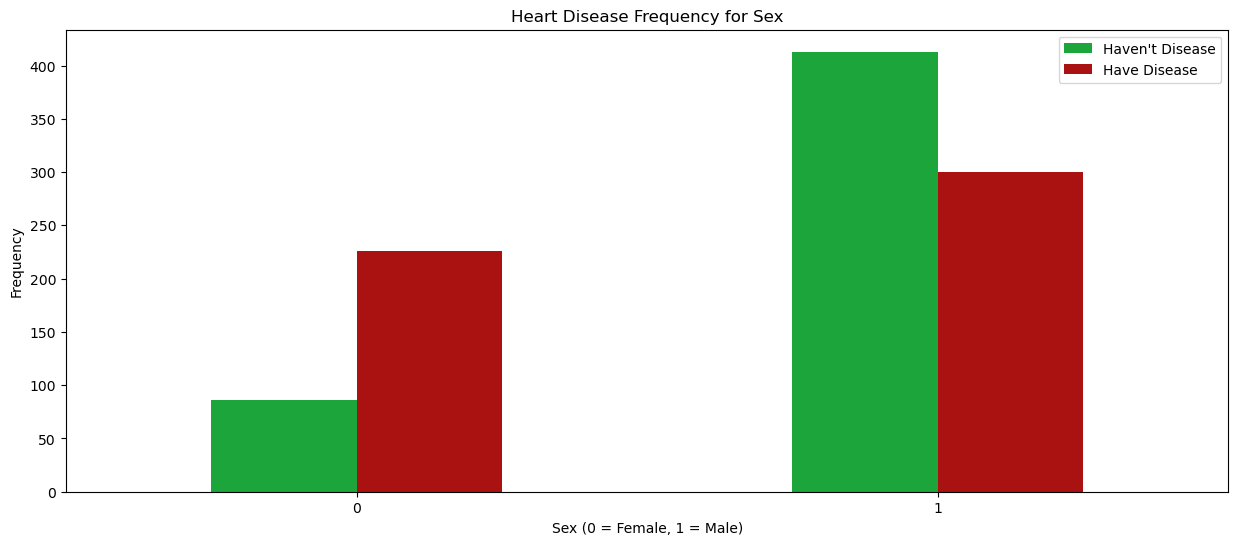

In [876]:
pd.crosstab(df.sex,df.target).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

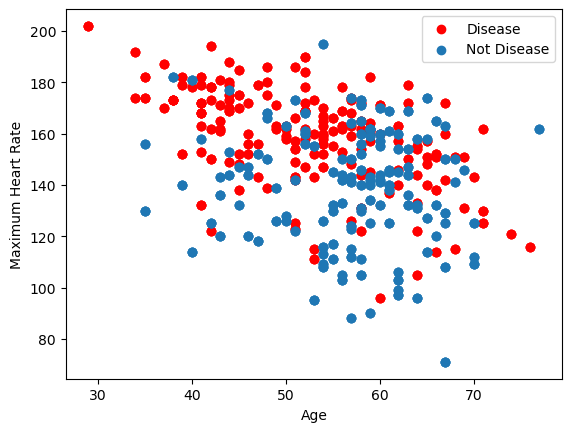

In [877]:
plt.scatter(x=df.age[df.target==1], y=df.thalach[(df.target==1)], c="red")
plt.scatter(x=df.age[df.target==0], y=df.thalach[(df.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

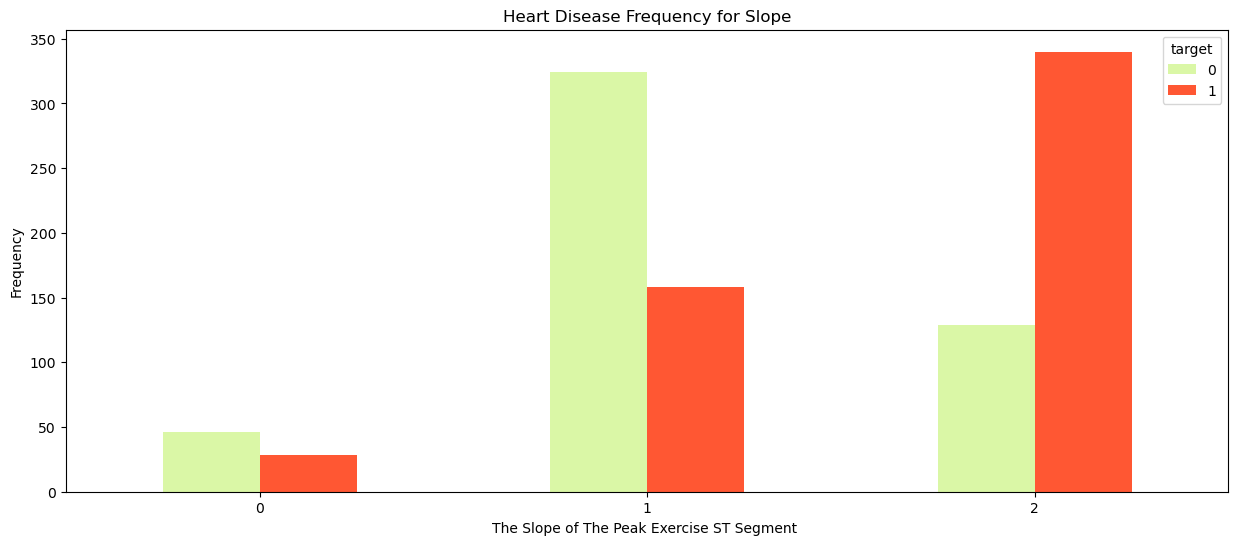

In [878]:
pd.crosstab(df.slope,df.target).plot(kind="bar", figsize=(15, 6), color=['#DAF7A6','#FF5733' ])
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment ')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

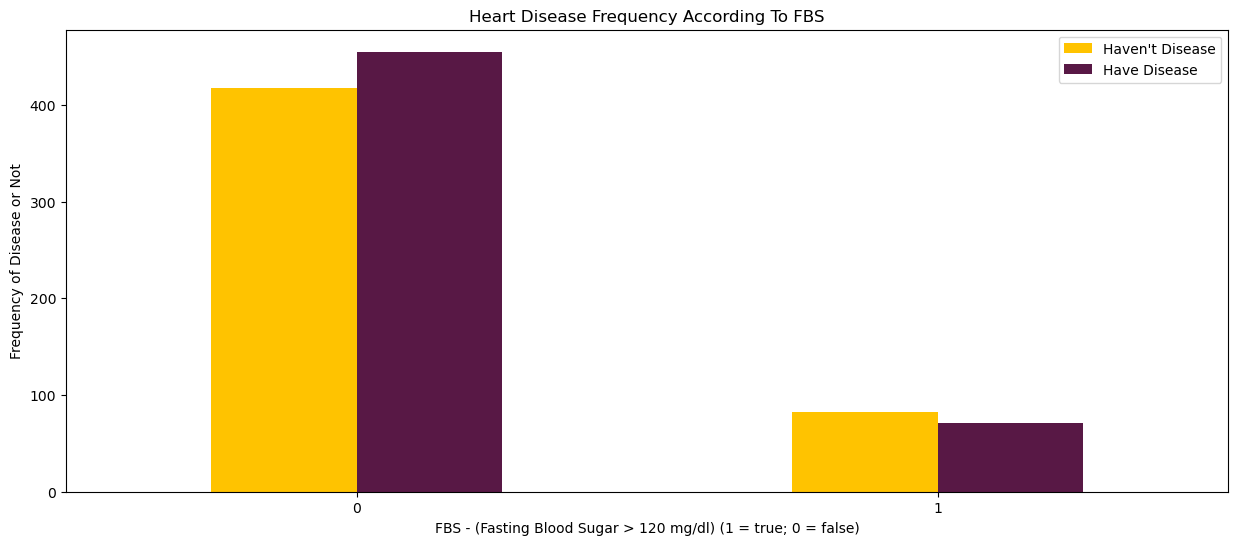

In [879]:
pd.crosstab(df.fbs,df.target).plot(kind="bar", figsize=(15, 6), color=['#FFC300','#581845' ])
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

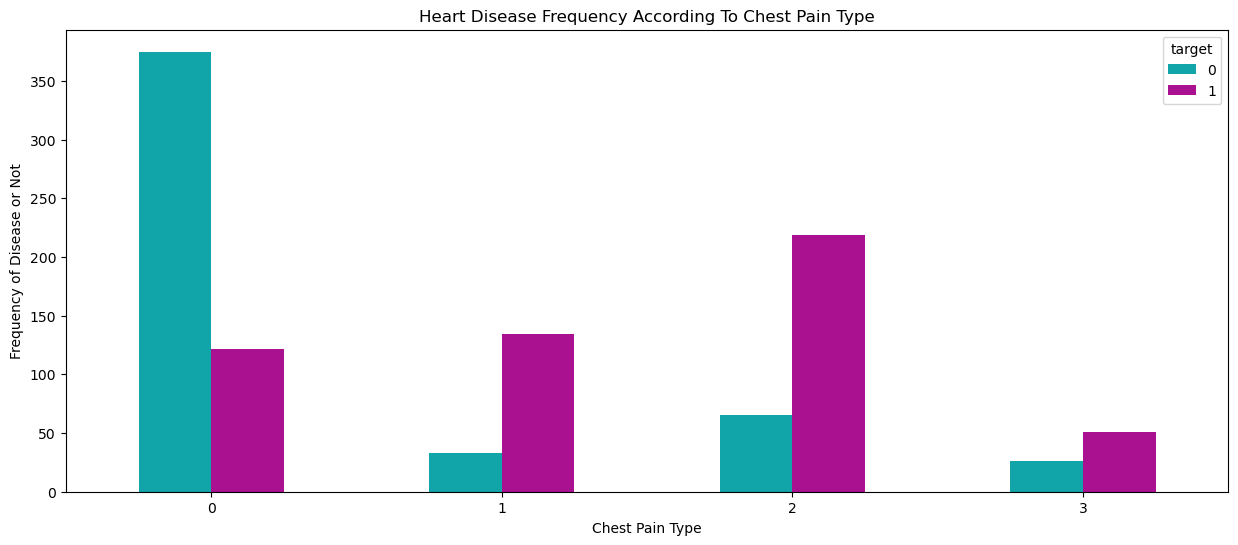

In [880]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(15, 6), color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()

### Преобразование категориальных признаков

Закодируем категориальные признаки **cp**, **thal** и **slope**.

In [881]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df.target

0       0
1       0
2       0
3       0
4       0
       ..
1020    1
1021    0
1022    0
1023    1
1024    0
Name: target, Length: 1025, dtype: int64

In [882]:
df = df.drop(columns = ['cp', 'chol', 'thal', 'slope'])
df.head()

,age,sex,trestbps,fbs,restecg,thalach,exang,oldpeak,ca,target,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,0,1,168,0,1.0,2,0,...,False,False,False,False,False,False,True,False,False,True
1,53,1,140,1,0,155,1,3.1,0,0,...,False,False,False,False,False,False,True,True,False,False
2,70,1,145,0,1,125,1,2.6,0,0,...,False,False,False,False,False,False,True,True,False,False
3,61,1,148,0,1,161,0,0.0,1,0,...,False,False,False,False,False,False,True,False,False,True
4,62,0,138,1,1,106,0,1.9,3,0,...,False,False,False,False,False,True,False,False,True,False


## 🚩Разбиение данных с использованием train_test_split и масштабирование

In [883]:
y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train.head(5)

,age,sex,trestbps,fbs,restecg,thalach,exang,oldpeak,ca,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,-1.481117,0.650566,-1.117672,-0.425115,0.931131,1.285426,-0.696311,-0.899374,-0.729676,-0.968428,-0.41792,1.586805,-0.301032,-0.054074,-0.27429,0.946059,-0.815505,-0.261793,-0.932314,1.060113
1,0.394729,0.650566,-0.378854,-0.425115,0.931131,-0.272293,-0.696311,-0.549171,3.041003,-0.968428,2.39280,-0.630197,-0.301032,-0.054074,-0.27429,-1.057017,1.226234,-0.261793,1.072600,-0.943296
2,-0.488022,0.650566,1.041951,-0.425115,-0.992832,-0.984393,-0.696311,1.376947,-0.729676,1.032601,-0.41792,-0.630197,-0.301032,-0.054074,-0.27429,-1.057017,1.226234,-0.261793,1.072600,-0.943296
3,-0.267335,0.650566,0.132636,-0.425115,0.931131,0.350795,-0.696311,-0.198968,0.212994,-0.968428,2.39280,-0.630197,-0.301032,-0.054074,-0.27429,0.946059,-0.815505,-0.261793,-0.932314,1.060113
4,-0.267335,0.650566,1.155616,2.352304,0.931131,1.240920,-0.696311,0.151236,-0.729676,-0.968428,-0.41792,-0.630197,3.321910,-0.054074,-0.27429,-1.057017,1.226234,-0.261793,1.072600,-0.943296


### Отбор наилучших признаков с помощью рекурсивного исключения признаков и кросс-валидации (RFECV)

In [884]:
rfecv = RFECV(estimator=RidgeClassifierCV())

rfecv.fit(X_train, y_train)

selected_features = list(X_train.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", selected_features)

Optimal features:  11
Selected features:  ['sex', 'trestbps', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'thal_0', 'thal_2', 'thal_3', 'slope_1']


In [885]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [886]:
X_train.head(5)

,sex,trestbps,thalach,exang,oldpeak,ca,cp_0,thal_0,thal_2,thal_3,slope_1
0,0.650566,-1.117672,1.285426,-0.696311,-0.899374,-0.729676,-0.968428,-0.054074,0.946059,-0.815505,-0.932314
1,0.650566,-0.378854,-0.272293,-0.696311,-0.549171,3.041003,-0.968428,-0.054074,-1.057017,1.226234,1.072600
2,0.650566,1.041951,-0.984393,-0.696311,1.376947,-0.729676,1.032601,-0.054074,-1.057017,1.226234,1.072600
3,0.650566,0.132636,0.350795,-0.696311,-0.198968,0.212994,-0.968428,-0.054074,0.946059,-0.815505,-0.932314
4,0.650566,1.155616,1.240920,-0.696311,0.151236,-0.729676,-0.968428,-0.054074,-1.057017,1.226234,1.072600


## Метод k-ближайших соседей. Реализация в классе KNN_Classifier

In [887]:
class KNN_Classifier(object):
    def __init__(self, num_neighbors=5):
        self._num_neighbors = num_neighbors
        self.y_pred = []
    
    def euclidean_distance(self, row, data):                      #получение расстояний для одной строки
        distances = np.array([])
        for i in range(data.shape[0]):
            distances = np.append(distances, (np.sqrt(((data[i] - row)**2).sum())))
        return distances.reshape(data.shape[0], )                 #возвращаем столбец

    def get_neighbors(self, distances, y):                     #выделение необходимых соседей и их метрик
        neighbours = np.column_stack([distances, y])            #присоединяем к столбцу расстояний метки классов этих строк
        neighbours = neighbours[np.argsort(neighbours[:, 0])]
        
        prediction = self.predict(neighbours[:self._num_neighbors, :])
        return prediction
    
    def predict(self, neighbors):
        vals, counts = np.unique(neighbors[:, -1:], return_counts=True)
        return (vals[np.argmax(counts)])
    
    def fit(self, X_train, X_test, y_train): #предсказываем тестовые значения на тренировочных данных
        for i in range(X_test.shape[0]):
            distances = self.euclidean_distance(X_test[i], X_train)
            self.y_pred.append(self.get_neighbors(distances, y_train))
        return self
    
    def accuracy(self, y):
        correct = 0
        for i in range(y.shape[0]):
#             if y.values[i] == self.y_pred[i]:
            if y[i] == self.y_pred[i]:
                correct += 1
        return (correct / (y.shape[0]))
    
    def get_params(self, deep=True):
        return {"num_neighbors": self._num_neighbors}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [888]:
knn = KNN_Classifier(3)

knn_fit = knn.fit(X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy())
knn_fit.y_pred[:10]


[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]

In [889]:
y_test[:10]

527    1
359    1
447    0
31     1
621    0
590    1
905    0
737    0
76     1
948    0
Name: target, dtype: int64

In [890]:
accuracy_score(y_test, knn_fit.y_pred)

0.9380530973451328

In [891]:
from sklearn.model_selection import KFold

# датасет
data = np.vstack([X_train, X_test])
target = np.concatenate([y_train, y_test])
data = np.column_stack([data, target])

res_table = pd.DataFrame({'#':['k-neighbours', 'accuracy-score']})

# подготовьте кросс валидацию
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
num_neighbours = [3, 5, 7, 9]
i = 1

best_acc = 0
nbrs = 0
idx = 0

# перечисление выборок датасета
for k in num_neighbours:
    i = 1
    for train, test in kfold.split(data):
        knn = KNN_Classifier(k)
        knn_fit = knn.fit(data[train], data[test], data[:, -1:][train])
        acc = knn.accuracy(data[:, -1:][test])
        row = [k, acc]
        res_table[f"Split-{i}.{k}"] = row
        if acc > best_acc:
            best_acc = acc  
            nbrs = k
            idx = i
        i+=1


In [892]:
print(f'Наилучшая точность %.4f достигается при %.f соседях на %.f сплите' % (best_acc, nbrs, idx))

Наилучшая точность 0.9805 достигается при 3 соседях на 2 сплите


In [893]:
res_table.iloc[:, :10]

,#,Split-1.3,Split-2.3,Split-3.3,Split-4.3,Split-5.3,Split-1.5,Split-2.5,Split-3.5,Split-4.5
0,k-neighbours,3.00000,3.000000,3.000000,3.00000,3.000000,5.000000,5.000000,5.000000,5.000000
1,accuracy-score,0.97561,0.980488,0.970732,0.95122,0.960976,0.936585,0.917073,0.892683,0.917073


## Проверка выполнения алгоритма с помощью библиотечных реализаций
***(logistic regression, svm, knn, naive bayes, decision tree)***

### Sklearn: LogisticRegression

In [894]:
from sklearn.linear_model import LogisticRegression
accuracies = {}

lr = LogisticRegression()
lr.fit(X_train, y_train)
acc = lr.score(X_test, y_test)

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.8466


### Sklearn: SVM

In [895]:
from sklearn.svm import SVC

svm = SVC(random_state = 12)
svm.fit(X_train, y_train)

acc = svm.score(X_test, y_test)
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.8761


### Sklearn: KNeighborsClassifier

In [896]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)  # n_neighbors means k
knn.fit(X_train, y_train)
prediction = knn.predict(X_test)

print("{} NN Score: {:.4f}".format(3, knn.score(X_test, y_test)))

3 NN Score: 0.9381


### Sklearn: naive_bayes

In [897]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

acc = nb.score(X_test, y_test)
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.4f}".format(acc))

Accuracy of Naive Bayes: 0.6224


### Sklearn: DecisionTreeClassifier

In [898]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

acc = dtc.score(X_test, y_test)
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.4f}".format(acc))

Decision Tree Test Accuracy 1.0000


## Confusion matrices

In [899]:
# Predicted values
my_knn = best_acc
y_head_lr = lr.predict(X_test)
knn3 = KNeighborsClassifier(n_neighbors = 3)
knn3.fit(X_train, y_train)
y_head_knn = knn3.predict(X_test)
y_head_svm = svm.predict(X_test)
y_head_nb = nb.predict(X_test)
y_head_dtc = dtc.predict(X_test)
knn = KNN_Classifier(3)
knn_fit = knn.fit(X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy())
y_head_knnc = knn_fit.y_pred

In [900]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_dtc = confusion_matrix(y_test, y_head_dtc)
cm_knnc = confusion_matrix(y_test, y_head_knnc)

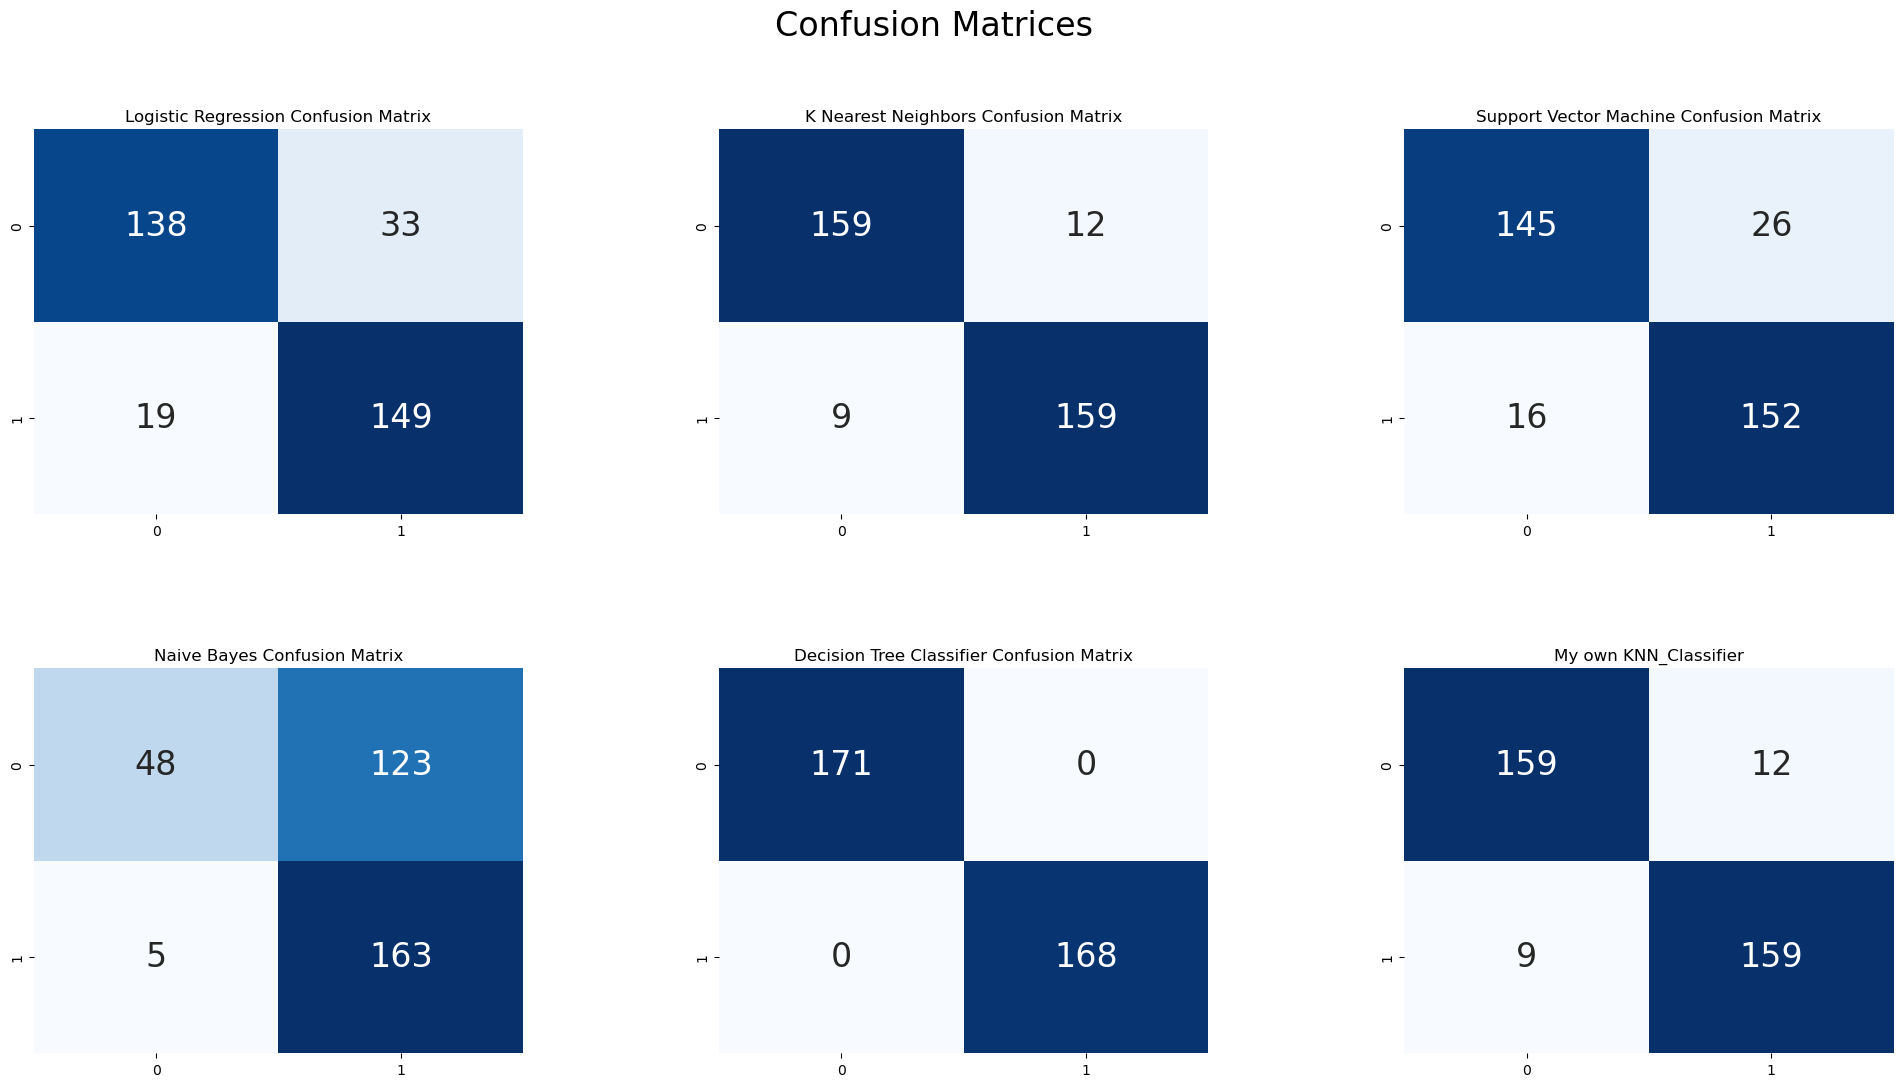

In [901]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,6)
plt.title("My own KNN_Classifier")
sns.heatmap(cm_knnc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

### Матрица разработанного решения(правый нижний угол) полностью совпадает с библиотечной реализацией KNN. Наилучшие показатели у Decision Tree Classifier.

## Logistic Regression. Реализация в классе LogR_Classifier

In [909]:
class LogR_Classifier(object):
    
    def __init__(self, n_iter = 100, learning_rate = 0.01):
        self.w = None
        self.b = 0.1
        self.n_iter = n_iter
        self.lr = learning_rate
        
    def fit(self, X, y):

        n = X.shape[0]
        m = X.shape[1]
        self.w = np.random.uniform(0,1, m) # colom 1
        print('w', self.w.shape)
        
        for i in range(10000):
            z = X.dot(self.w) + self.b
            y_pred = self.sigmoid(z)
            l = self.square_loss(y_pred, y)        
            gradient_W = np.dot((y_pred-y).T, X)/m
            gradient_b = np.mean(y_pred-y)
            self.w -= self.lr * gradient_W
            self.b -= self.lr * gradient_b
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def square_loss(self, y_pred, target):
        return np.mean((y_pred - target)**2)
    
    def predict(self, X):
        res = np.array([])
        res = np.append(res, self.sigmoid(np.dot(X, self.w) + self.b))
        return np.where(res >= 0.5, 1, 0)

In [910]:
X_train.shape

(686, 11)

In [911]:
logr = LogR_Classifier(100, 0.01)
logr_fit = logr.fit(X_train.to_numpy(), y_train.to_numpy())

w (11,)


In [912]:
y_pred = logr.predict(X_train)
y_pred[:10]

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1])

In [913]:
y_pred.shape

(686,)

In [914]:
y_train[:10]

866    1
749    1
212    0
79     1
148    1
302    1
798    0
633    0
523    0
365    1
Name: target, dtype: int64

In [915]:
accuracy_score(y_train, y_pred)

0.8746355685131195

In [917]:
y_pred_test = logr.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.8407079646017699